In [1]:
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import L_BFGS_B, SPSA
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit.circuit.library import TwoLocal
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import QuantumCircuit
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit_nature.second_q.mappers import ParityMapper

In [2]:
driver = PySCFDriver(
    atom="Li 0 0 0; H 0 0 1.6",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

In [3]:
mapper = ParityMapper(num_particles=es_problem.num_particles)
mapper = es_problem.get_tapered_mapper(mapper)

In [4]:
print("Hamiltonian of Molecule:")
hamiltonian = es_problem.hamiltonian.second_q_op()
qubit_op = mapper.map(hamiltonian)
aux_op = mapper.map(es_problem.second_q_ops()[1])
for pauli, coeff in sorted(qubit_op.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

Hamiltonian of Molecule:
-4.97160169 * IIIIIIII
+0.01431929 * IIIIIIIX
+1.00649888 * IIIIIIIZ
-0.00747751 * IIIIIIXI
+0.00312967 * IIIIIIXX
-0.00055888 * IIIIIIXZ
-0.02534773 * IIIIIIYY
+0.08834087 * IIIIIIZI
-0.01431929 * IIIIIIZX
-0.11846054 * IIIIIIZZ
-0.00133902 * IIIIIXIX
-0.00419157 * IIIIIXIZ
-0.00814755 * IIIIIXXI
+0.00166630 * IIIIIXXX
-0.00530923 * IIIIIXXZ
+0.00288256 * IIIIIXYY
-0.01468666 * IIIIIXZI
+0.00105661 * IIIIIXZX
+0.00500544 * IIIIIXZZ
-0.00028241 * IIIIIYIY
+0.00166630 * IIIIIYXY
-0.00530923 * IIIIIYYI
-0.00288256 * IIIIIYYX
-0.00814755 * IIIIIYYZ
-0.38500533 * IIIIIZII
-0.00078811 * IIIIIZIX
+0.08829539 * IIIIIZIZ
+0.00286246 * IIIIIZXI
-0.00391055 * IIIIIZYY
+0.00078811 * IIIIIZZX
+0.08247949 * IIIIIZZZ
+0.01431929 * IIIIXIII
+0.00333439 * IIIIXIIX
+0.02792749 * IIIIXIIZ
-0.00083735 * IIIIXIXI
-0.00280394 * IIIIXIYY
-0.00333439 * IIIIXIZX
-0.00155258 * IIIIXIZZ
+0.00222667 * IIIIXXXX
-0.00117317 * IIIIXXXZ
+0.00091670 * IIIIXXZI
+0.00222667 * IIIIXYXY
-0.001173

In [5]:
class ThermalNoiseModel(NoiseModel):
    def __init__(self, t1, t2):
        super().__init__()
        self.t1 = t1
        self.t2 = t2
        self.time_cx = 150
        self.time_swap = 40
        self.single_gate_times = {
            "h": 40,
            "x": 40,
            "y": 40,
            "z": 40,
            "s": 40,
            "rx": 40,
            "rz": 40,
            "sdg": 40,
        }

        self.add_errors()

    def add_errors(self):
        for gate, time in self.single_gate_times.items():
            self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, time), gate)
        self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, self.time_cx)
            .expand(thermal_relaxation_error(self.t1, self.t2, self.time_cx)), "cx")
        self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, self.time_swap)
            .expand(thermal_relaxation_error(self.t1, self.t2, self.time_swap)), "swap")

In [6]:
seed = 100

noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": [(0, 1), (1, 2)],
        "noise_model": ThermalNoiseModel(10e3, 5e3),
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

noiseless_estimator = AerEstimator(
    approximation=True,
    backend_options={

    },
    # run_options={"seed": seed, "shots": 1024},
    # transpile_options={"seed_transpiler": seed}
)

In [7]:
ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

ansatz = TwoLocal(
    rotation_blocks=["h", "rx"],
    entanglement_blocks="cz",
    entanglement="full",
    reps=2,
    parameter_prefix="y",
)


vqe = VQE(noiseless_estimator, ansatz, L_BFGS_B())
# vqe.initial_point = [0.0] * ansatz.num_parameters

In [8]:
for gate, cnt in ansatz.decompose(reps=3).count_ops().items():
    print(f"{gate.upper()} Gate - {cnt}")

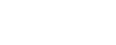

In [9]:
ansatz.decompose(reps=3).draw(output="mpl")

In [12]:
result = vqe.compute_minimum_eigenvalue(qubit_op, aux_op)
res = es_problem.interpret(result)
res.total_energies[0]

-7.358803586052937

In [11]:
calculated = res.eigenvalues[0] + res._nuclear_repulsion_energy
actual = res._hartree_fock_energy
print("Total Calculated Energy:", calculated)
print("Actual Energy:", res._hartree_fock_energy)
print(f"Percentage Error: {(calculated - actual) / calculated * 100:.4f}%")

Total Calculated Energy: -7.3588035860950844
Actual Energy: -7.861864769808656
Percentage Error: -6.8362%


In [13]:
# distances = np.hstack((np.arange(0.2, 1.55, 0.05), np.arange(1.75, 4.25, 0.25)))
distances = np.arange(0.5, 4.25, 0.05)
vqe_energies = []
reference_energies = []

for distance in tqdm(distances, desc="Calculating energies"):
    driver = PySCFDriver(
        atom=f"Li 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    es_problem = driver.run()
    mapper = ParityMapper(num_particles=es_problem.num_particles)
    mapper = es_problem.get_tapered_mapper(mapper)
    qubit_op, aux_op = es_problem.second_q_ops()
    qubit_op, aux_op = mapper.map(qubit_op), mapper.map(aux_op)
    raw_result = vqe.compute_minimum_eigenvalue(qubit_op, aux_op)
    res = es_problem.interpret(raw_result)
    vqe_energies.append(res.total_energies[0])
    reference_energies.append(res._hartree_fock_energy)

Calculating energies: 100%|██████████| 75/75 [10:15<00:00,  8.20s/it]


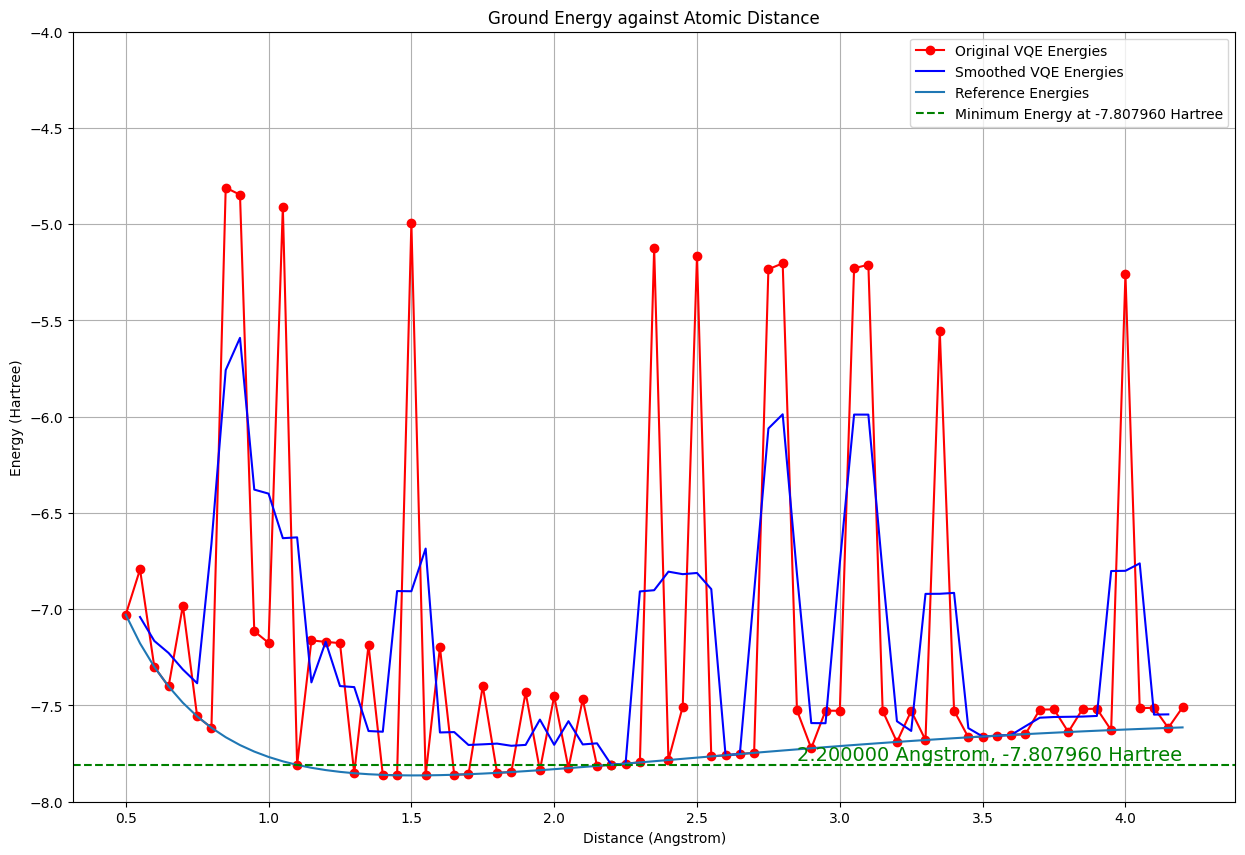

The minimum energy is -7.807960 Hartree at a distance of 2.200000 Angstrom


In [25]:
kernel_size = 3
kernel = np.ones(kernel_size) / kernel_size
vqe_energies = np.array(vqe_energies)

# Apply convolution to smooth the energies
smoothed_energies = np.convolve(vqe_energies, kernel, mode='valid')

# Adjust distances to match the length of the smoothed energies
adjusted_distances = distances[(kernel_size-1)//2:-(kernel_size-1)//2] if kernel_size % 2 != 0 else distances[(kernel_size)//2:-(kernel_size)//2]

# Find the minimum energy and corresponding distance
min_energy = smoothed_energies.min()
min_energy_distance = adjusted_distances[smoothed_energies.argmin()]

# Plot the original and smoothed energies
plt.figure(figsize=(15, 10))
plt.plot(distances, vqe_energies, 'o-', label='Original VQE Energies', color='red')
plt.plot(adjusted_distances, smoothed_energies, '-', label='Smoothed VQE Energies', color='blue')
plt.plot(distances, reference_energies, '-', label='Reference Energies')

# Draw a horizontal line at the minimum energy point
plt.axhline(min_energy, color='green', linestyle='--', label=f'Minimum Energy at {min_energy:.6f} Hartree')
plt.scatter(min_energy_distance, min_energy, color='green')  # Mark the minimum point
plt.text(distances[-1], min_energy, f'{min_energy_distance:.6f} Angstrom, {min_energy:.6f} Hartree', color='green', fontsize=14, ha='right', va='bottom')


plt.xlabel('Distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Ground Energy against Atomic Distance')
plt.ylim(-8, -4)
plt.legend()
plt.grid(True)
plt.show()

print(f"The minimum energy is {min_energy:.6f} Hartree at a distance of {min_energy_distance:.6f} Angstrom")